In [1]:
from mayavi import mlab
mlab.init_notebook()
mlab.options.offscreen = True

Notebook initialized with ipy backend.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import plot_tools as pt
import sim_tools as st
import vector_tools as vt
import pandas as pd
import hyperspy.api as hs
import mag_sim_tools as mst
import mag_plot_tools as mpt

import scipy as sp
# from skimage.restoration import unwrap_phase
from smooth_hsv_trh import smooth_hsv as hsv
import smooth_hsv_jjc as smooth_hsv
# from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import Normalize
import os

from mpl_toolkits.mplot3d import axes3d
from scipy import ndimage
from scipy import signal
import imageio
from matplotlib.colors import colorConverter

import colorsys
import math

In [3]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

In [32]:
# create skyrmion using mag_sim_tools
######################################
### USER INPUT

BASE = str("/Users/fehmiyasin/RIKEN/Research/Illustrations/spin_textures/")

PIX_LEN = 8                                         # nm/PIX (pixel length)
PIX_T = 8                                           # nm/PIX (pixel length)


T_PIX = 60                            #pix (number of pixels in z (thickness))
N_PIX = 60                          #pix (number of pixels along x and y lengths)

M = np.zeros((3,T_PIX,N_PIX,N_PIX),dtype=np.float64)

FOV_L = PIX_LEN*N_PIX #nm
THICKNESS = T_PIX*PIX_T
print('FOV is ' + str(FOV_L) + ' nm.' + ' Thickness is ' + str(THICKNESS) + ' nm.')
RAD = 100

CENTERS = [[0,0]]
######################################
#Bloch Type:
M[0],M[1],M[2] = mst.skyrmion(m=-1, gamma=3*np.pi/2, r=RAD,
                              width=2., centers=CENTERS,
                              pxsize=PIX_LEN, Npixels=N_PIX)

FOV is 480 nm. Thickness is 480 nm.


In [47]:
print(np.pi)

3.141592653589793


In [62]:
M2 = np.zeros((3,T_PIX,128,128),dtype=np.float64)
N_HELICES = 10
ANGLE = np.linspace(0,N_HELICES * 2 * np.pi,128)
X,Y = np.meshgrid(ANGLE, ANGLE)
for z,_ in enumerate(M2[0]):
#     print(z)
    M2[1,z] = np.cos(X)
    M2[2,z] = np.sin(X)
M2[:,:,40:80,20:60] = np.copy(M[:,:,10:50,10:50])

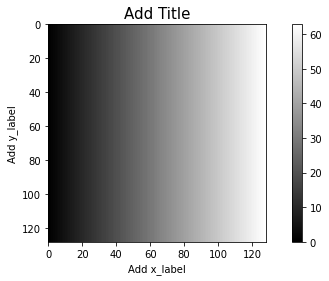

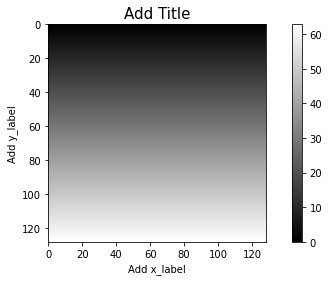

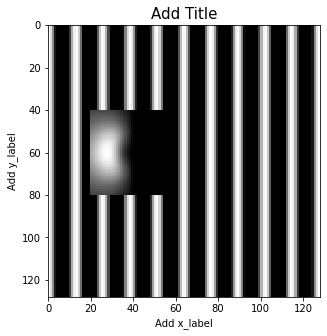

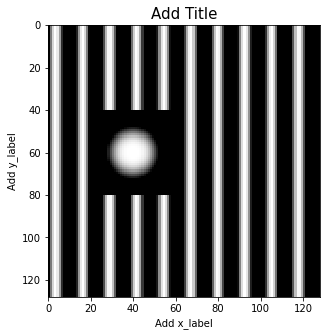

In [63]:
pt.plot_2D(X, colorbar=True)
pt.plot_2D(Y, colorbar=True)
pt.plot_2D(M2[1,0])
pt.plot_2D(M2[2,0])

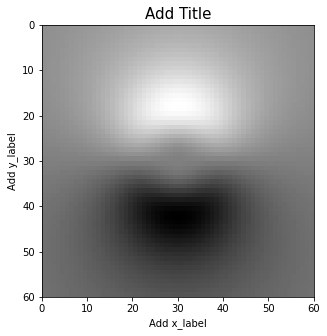

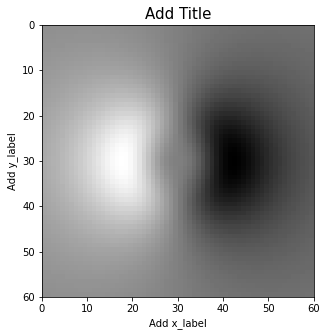

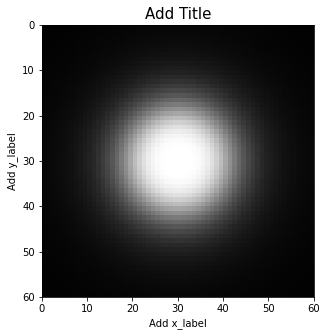

In [33]:
for _,mag in enumerate(M):
    pt.plot_2D(mag[0], vmin=-1, vmax=+1)

[-0.99860367 -0.99860367 -0.99176007 ...  0.99860367  0.99947444
  1.        ]


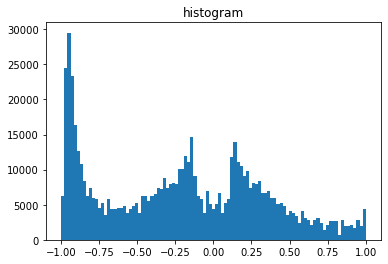

In [34]:
print(np.unique(M))
BINS = np.linspace(np.min(M), np.max(M), 100)

plt.hist(M.flatten(), bins=BINS) 
plt.title("histogram") 
plt.show()

In [35]:
M_ROTF_TEMP = mst.rotate_3d_vec2(mag=M,angx=[0],angy=[0],angz=[0],#-40],
                                 pix=PIX_LEN,PAD=True,TEST=True)

0it [00:00, ?it/s]

0 (0, 0, 0)
0 0
1 0
2 0
ANGLE= (0, 0, 0)


1it [00:00,  2.87it/s]

(3, 60, 60, 60)
[-0.99860367 -0.99860367 -0.99860367 ...  1.          1.
  1.        ] 0
[-0.99860367 -0.99860367 -0.99860367 ...  1.          1.
  1.        ] 1
np.shape(TEMP)= (3, 60, 60, 60)
MIDY, MIDX, LENY, LENX 30 30 60 60


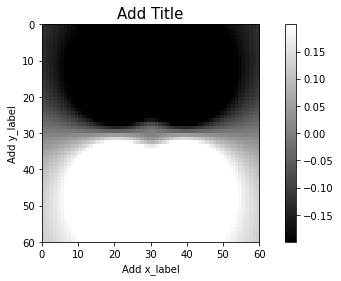

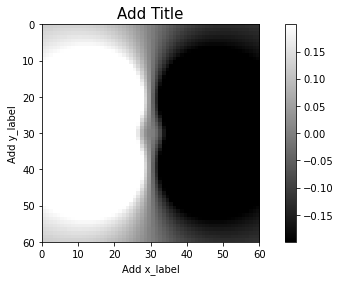

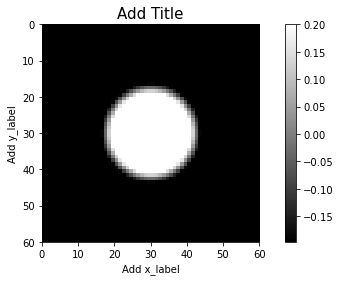

In [36]:
# Rotate the array without rotating the vectors in order to keep the colormap the same
# during 3D vector plotting bottom-right to top-left slice: angle=-63, +65
M_ROTF = np.copy(M_ROTF_TEMP[0])
for i,im in enumerate(M_ROTF):
    M_ROTF[i] = np.copy(im)
    pt.plot_2D(np.mean(im,axis=0),#[25:105,30:95],
               vmin=np.min(im)/5, vmax = np.max(im)/5,
               colorbar=True, origin='lower')

In [37]:
MX = np.array(np.copy(M_ROTF[0]),dtype=np.float32)
MY = np.array(np.copy(M_ROTF[1]),dtype=np.float32)
MZ = np.array(np.copy(M_ROTF[2]),dtype=np.float32)

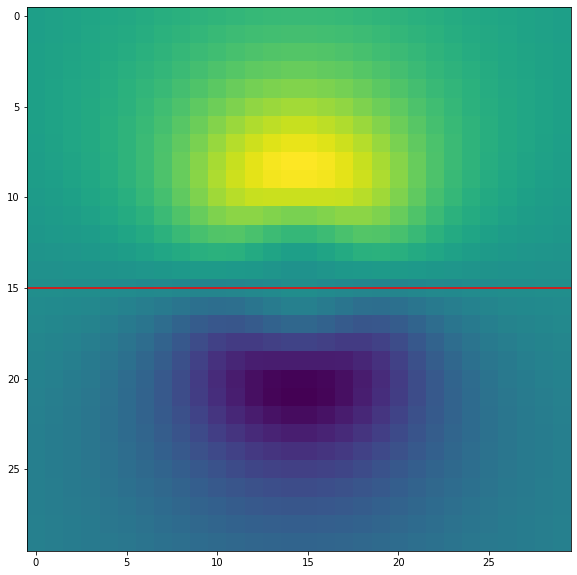

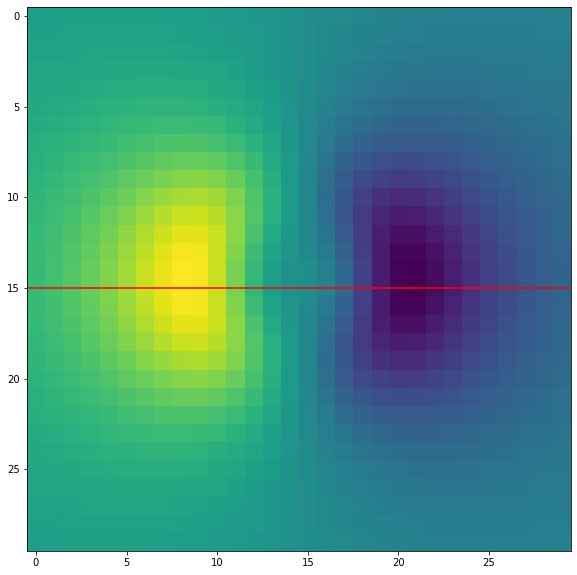

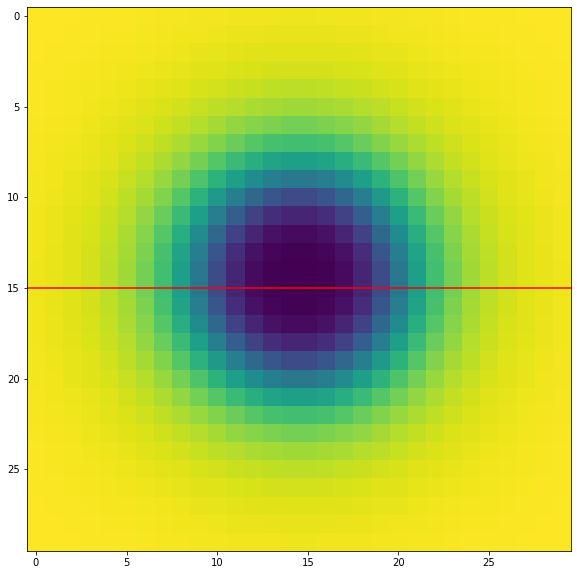

In [38]:
MX_NORM=np.array(np.copy(MX)/np.max(np.abs(M_ROTF)),
                 dtype=np.float32)
MY_NORM=np.array(np.copy(MY)/np.max(np.abs(M_ROTF)),
                 dtype=np.float32)
MZ_NORM=-np.array(np.copy(MZ)/np.max(np.abs(M_ROTF)),
                 dtype=np.float32)
BIN = 2

MX_NORM = bin_ndarray(np.copy(MX_NORM),
                      (MX_NORM.shape[0] // BIN * 1,
                       MX_NORM.shape[1] // BIN,
                       MX_NORM.shape[2] // BIN), operation='mean')
MY_NORM = bin_ndarray(np.copy(MY_NORM),
                      (MY_NORM.shape[0] // BIN * 1,
                       MY_NORM.shape[1] // BIN,
                       MY_NORM.shape[2] // BIN), operation='mean')
MZ_NORM = bin_ndarray(np.copy(MZ_NORM),
                      (MZ_NORM.shape[0] // BIN * 1,
                       MZ_NORM.shape[1] // BIN,
                       MZ_NORM.shape[2] // BIN), operation='mean')

THICKNESS = 256 #nm
PIX = PIX_LEN * BIN
PIX_LEN_T = THICKNESS / T_PIX * BIN//1

M_NORM = np.array([MX_NORM,MY_NORM,MZ_NORM])
for i,im in enumerate([MX_NORM,MY_NORM,MZ_NORM]):
    plt.figure(figsize=(10,10))
    plt.imshow(np.mean(im,axis=0), vmin = np.min(np.mean(im,axis=0)))
    plt.axhline(im.shape[1] // 2, c='r')
    plt.show()
    
    
# MX_NORM=np.array(np.copy(MX)/np.max(np.abs(M_ROTF)),
#                  dtype=np.float32)
# MY_NORM=np.array(np.copy(MY)/np.max(np.abs(M_ROTF)),
#                  dtype=np.float32)
# MZ_NORM=-np.array(np.copy(MZ)/np.max(np.abs(M_ROTF)),
#                  dtype=np.float32)
# M_NORM = np.array([MX_NORM,MY_NORM,MZ_NORM])
# for i,im in enumerate([MX_NORM,MY_NORM,MZ_NORM]):
#     plt.figure(figsize=(10,10))
#     plt.imshow(np.mean(im,axis=0), vmin = np.min(np.mean(im,axis=0)))
#     plt.show()

In [39]:
print(np.shape(M_NORM), BASE)

(3, 30, 30, 30) /Users/fehmiyasin/RIKEN/Research/Illustrations/spin_textures/


In [40]:
FN = BASE+'230322_M_3D_30'
# mst.npy_to_ovf(m_array=np.array([MX_NORM,MY_NORM,MZ_NORM]),
#                file_name=str(FN),
#                xpix_len=PIX,
#                ypix_len=PIX,
#                zpix_len=PIX_LEN_T)

In [41]:
#### For plotting xz slices.
# MX_NORM_PLOT = np.rollaxis(np.copy(MX_NORM)[30:94,:-1,:-1], 1)#[10:114,10:114,10:114]#[30:94,:-1,:-1]
# MY_NORM_PLOT = np.rollaxis(np.copy(MZ_NORM)[30:94,:-1,:-1], 1)#[10:114,10:114,10:114]#[30:94,:-1,:-1]
# MZ_NORM_PLOT = -np.rollaxis(np.copy(MY_NORM)[30:94,:-1,:-1], 1)

MX_NORM_PLOT = np.copy(MX_NORM)[:,:,:]#[10:114,10:114,10:114]#[30:94,:-1,:-1]
MY_NORM_PLOT = np.copy(MY_NORM)[:,:,:]#[10:114,10:114,10:114]#[30:94,:-1,:-1]
MZ_NORM_PLOT = np.copy(MZ_NORM)[:,:,:]#[10:114,10:114,10:114]#[30:94,:-1,:-1]
MX_NORM_PLOT = np.copy(MX_NORM_PLOT)/np.max(np.abs([MX_NORM_PLOT,MY_NORM_PLOT,MZ_NORM_PLOT]))
MY_NORM_PLOT = np.copy(MY_NORM_PLOT)/np.max(np.abs([MX_NORM_PLOT,MY_NORM_PLOT,MZ_NORM_PLOT]))
MZ_NORM_PLOT = np.copy(MZ_NORM_PLOT)/np.max(np.abs([MX_NORM_PLOT,MY_NORM_PLOT,MZ_NORM_PLOT]))

print(np.shape(MX_NORM_PLOT))

(30, 30, 30)


In [42]:
## Mayavi glyph plots 1/3
SV_DIR = str(BASE)#+'230221_Neel_SKY_ROT/'
if not os.path.exists(str(SV_DIR)):
    os.makedirs(str(SV_DIR))
SAVE_FN = str(SV_DIR)+"Sky3_glyphs_15"

mlab.close('all')
mlab.clf()
# for t_slice in np.arange(np.shape(MX_NORM_PLOT)[0]-45):
    
X_SLICE = [0,MX_NORM_PLOT.shape[2]]
Y_SLICE = [0,MX_NORM_PLOT.shape[1]]
Z_SLICE = [0,MX_NORM_PLOT.shape[0]]
X_LEN = X_SLICE[1]-X_SLICE[0]
Y_LEN = Y_SLICE[1]-Y_SLICE[0]
Z_LEN = Z_SLICE[1]-Z_SLICE[0]

BOX_BP1 = slice(Y_SLICE[0],Y_SLICE[1]),slice(X_SLICE[0],X_SLICE[1])
MX_NORM_PLOT2 = np.zeros((Z_LEN,Y_LEN,X_LEN))
MY_NORM_PLOT2 = np.zeros_like(MX_NORM_PLOT2)
MZ_NORM_PLOT2 = np.zeros_like(MX_NORM_PLOT2)
for i,_ in enumerate(MX_NORM_PLOT2):
    MX_NORM_PLOT2[i] = np.copy(MX_NORM_PLOT[Z_SLICE[0]+i])[BOX_BP1]
    MY_NORM_PLOT2[i] = np.copy(MY_NORM_PLOT[Z_SLICE[0]+i])[BOX_BP1]
    MZ_NORM_PLOT2[i] = np.copy(MZ_NORM_PLOT[Z_SLICE[0]+i])[BOX_BP1]

###### The following transpose is necessary for Mayavi plotting, and switches the array
###### indexing from '[z, y, x]'' to '[x, y, z]'
MX_NORM_PLOT3 = np.transpose(np.copy(MX_NORM_PLOT2))
MY_NORM_PLOT3 = np.transpose(np.copy(MY_NORM_PLOT2))
MZ_NORM_PLOT3 = np.transpose(np.copy(MZ_NORM_PLOT2))
####The following code normalizes each vector in the magnetic field
NORM_VAL = np.sqrt(MX_NORM_PLOT3 ** 2 + MY_NORM_PLOT3 ** 2 + MZ_NORM_PLOT3 ** 2)
MX_NORM_PLOT3 = np.copy(MX_NORM_PLOT3) / NORM_VAL
MY_NORM_PLOT3 = np.copy(MY_NORM_PLOT3) / NORM_VAL
MZ_NORM_PLOT3 = np.copy(MZ_NORM_PLOT3) / NORM_VAL
MX_NORM_PLOT2 = np.transpose(np.copy(MX_NORM_PLOT2))
MY_NORM_PLOT2 = np.transpose(np.copy(MY_NORM_PLOT2))
MZ_NORM_PLOT2 = np.transpose(np.copy(MZ_NORM_PLOT2))

In [43]:
## Mayavi plots part 2/3
COLORS = (np.random.random((np.size(MX_NORM_PLOT2), 4))*255).astype(np.uint8)
COLORS[:,-1] = 255 # No transparency

PHI = np.angle((MY_NORM_PLOT2)+1.j*(MX_NORM_PLOT2))
A = np.abs((MY_NORM_PLOT2)+1.j*(MX_NORM_PLOT2))
B_C=A*np.exp(1.0j*PHI)
COL_IN_PLANE = []

for i,_ in enumerate(B_C):
    COL_IN_PLANE.append(smooth_hsv.smooth_hsv(B_C[i],norm=1.,intensity_scale=1.))
COL_IN_PLANE = np.array(COL_IN_PLANE)

for i,_ in enumerate(np.ravel(MX_NORM_PLOT2)):
    ### I added a cubed root on 221128 in order to make the colors skew more 'in-plane'
    THETA = (((((np.arccos(np.ravel(np.copy(MZ_NORM_PLOT2))[i]) - (np.pi / 2)) /
                (np.pi / 2)) ** 3) * (np.pi / 2)) + (np.pi / 2))
#     THETA = (np.arccos(np.ravel(np.copy(MZ_NORM_PLOT2))[i]))
    
    COL_IN_PLANE_TEMP = np.reshape(COL_IN_PLANE,
                                   (np.shape(COL_IN_PLANE)[0]*
                                    np.shape(COL_IN_PLANE)[1]*
                                    np.shape(COL_IN_PLANE)[2],
                                    np.shape(COL_IN_PLANE)[3]))[i]

    TEMP0 = (np.sin(THETA)*COL_IN_PLANE_TEMP[0]+(np.cos(THETA)+1)/2)
    TEMP1 = (np.sin(THETA)*COL_IN_PLANE_TEMP[1]+(np.cos(THETA)+1)/2)
    TEMP2 = (np.sin(THETA)*COL_IN_PLANE_TEMP[2]+(np.cos(THETA)+1)/2)
    if TEMP0>1 or TEMP1>1 or TEMP2>1:
        TEMP0/=np.max([TEMP0,TEMP1,TEMP2])
        TEMP1/=np.max([TEMP0,TEMP1,TEMP2])
        TEMP2/=np.max([TEMP0,TEMP1,TEMP2])
    COLORS[i][0] = 255*TEMP0
    COLORS[i][1] = 255*TEMP1
    COLORS[i][2] = 255*TEMP2

In [44]:
# MX_NORM_PLOT2 = np.copy(MX_NORM_PLOT3)
# MY_NORM_PLOT2 = np.copy(MY_NORM_PLOT3)
# MZ_NORM_PLOT2 = np.copy(MZ_NORM_PLOT3)

In [45]:
print(PIX_LEN,PIX_LEN_T)

8 8.0


In [46]:
## Mayavi plots part 3/3
THICKNESS_ASKY = 32 # pixels
T_CENTER = Z_LEN//2

mlab.clf()
mlab.figure(bgcolor = (0.2,0.2,0.2))

# for i in np.arange(Z_LEN):
#     if i<8 or i>50 or np.logical_and(i>7,i<34) or np.logical_and(i>34,i<56):
#         print(i)
#         MX_NORM_PLOT2[:,:,i] = np.zeros_like(MX_NORM_PLOT2[:,:,i])
#         MY_NORM_PLOT2[:,:,i] = np.zeros_like(MY_NORM_PLOT2[:,:,i])
#         MZ_NORM_PLOT2[:,:,i] = np.zeros_like(MZ_NORM_PLOT2[:,:,i])

x, y, z = np.mgrid[-50 * PIX/PIX_LEN_T:50 * PIX/PIX_LEN_T:30j,
                   -50 * PIX/PIX_LEN_T:50 * PIX/PIX_LEN_T:30j,
                   -50:50:30j]
#     z*=5
scalars = np.arange(np.size(MX_NORM_PLOT2))

fig = mlab.figure(bgcolor=(1, 1, 1))

# obj = mlab.quiver3d(x,y,z,
#                     (MX_NORM_PLOT2),
#                     (MY_NORM_PLOT2),
#                     (MZ_NORM_PLOT2),
#                     extent = [np.min(x), np.max(x),
#                               np.min(y), np.max(y),
#                               np.min(z), np.max(z)],
#                     mode='cone',
#                     scalars=scalars,
#                     scale_mode='vector',
#                     scale_factor=5.,
# #                         vmax=1,
#                     colormap='RdBu')
# obj.glyph.color_mode = 'color_by_scalar' # Color by scalar

# # Set look-up table and redraw
# obj.module_manager.scalar_lut_manager.lut.table = COLORS

obj2_plot = np.ones_like(MX_NORM_PLOT3)*((MZ_NORM_PLOT3**2))

B_IP = np.sqrt(np.copy(MX_NORM_PLOT3)**2+np.copy(MY_NORM_PLOT3)**2)
B_IP = np.copy(B_IP)-np.min(B_IP)
B_IP = (np.copy(B_IP)/np.max(B_IP))
B_IP[:,:10,:] = 0
B_IP[:,-10:,:] = 0
B_IP[:10,:,:] = 0
B_IP[-10:,:,:] = 0
#     B_IP[B_IP<0.3] = 0
#     B_IP[B_IP>0.5] = 0
PHI2 = (np.angle((MY_NORM_PLOT3)+1.j*(MX_NORM_PLOT3)))
#     PHI2[np.abs(np.sin(PHI2))>(0.707+0.1)] = 0
#     PHI2[np.abs(np.sin(PHI2))<(0.707-0.1)] = 0
PHI3 = np.ones_like(PHI2)
PHI3*=np.min(PHI2)
#Make slices to plot the bloch points
BP1 = slice(19,25),slice(12,18),slice(23,33)
BP2 = slice(19,25),slice(45,51),slice(31,41)
BP3 = slice(38,44),slice(12,18),slice(30,40)
BP4 = slice(37,43),slice(46,52),slice(25,35)

#Make slices to plot the bloch lines
BL1 = slice(19,25),slice(11,17),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                    Z_LEN//2 + THICKNESS_ASKY//2)
BL2 = slice(19,25),slice(46,52),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                     Z_LEN//2 + THICKNESS_ASKY//2)

# BL3 = slice(39,45),slice(11,17),slice(Z_LEN//2 - THICKNESS_ASKY//2,
#                                      Z_LEN//2 + THICKNESS_ASKY//2)
######## For Bloch Point 1
BL2 = slice(22,23),slice(44,54),slice(30,45)
BL3 = slice(17,27),slice(48,49),slice(30,45)
BL4 = slice(17,27),slice(44,54),slice(36,37)
########

### Bloch line 1 alone
# BL3 = slice(22,23),slice(48,49),slice(Z_LEN//2 - THICKNESS_ASKY//2,
#                                     Z_LEN//2 + THICKNESS_ASKY//2)
# BL4 = slice(39,45),slice(46,52),slice(Z_LEN//2 - THICKNESS_ASKY//2,
#                                       Z_LEN//2 + THICKNESS_ASKY//2)
PHI3[BL1] = np.copy(PHI2[BL1])
PHI3[BL2] = np.copy(PHI2[BL2])
PHI3[BL3] = np.copy(PHI2[BL3])
PHI3[BL4] = np.copy(PHI2[BL4])
PHI4 = np.ones_like(PHI2)
PHI4*=np.min(PHI2)-1
MX_NORM_PLOT4 = np.zeros_like(MX_NORM_PLOT3)
MY_NORM_PLOT4 = np.zeros_like(MY_NORM_PLOT3)
MZ_NORM_PLOT4 = np.zeros_like(MZ_NORM_PLOT3)
W1 = slice(20,21),slice(12,51),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                     Z_LEN//2 + THICKNESS_ASKY//2)
W2 = slice(42,43),slice(12,51),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                     Z_LEN//2 + THICKNESS_ASKY//2)
W3 = slice(20,43),slice(50,51),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                     Z_LEN//2 + THICKNESS_ASKY//2)
W4 = slice(20,43),slice(12,13),slice(Z_LEN//2 - THICKNESS_ASKY//2,
                                     Z_LEN//2 + THICKNESS_ASKY//2)
# MX_NORM_PLOT4[W1] = MX_NORM_PLOT3[W1]
# MY_NORM_PLOT4[W1] = MY_NORM_PLOT3[W1]
# MZ_NORM_PLOT4[W1] = MZ_NORM_PLOT3[W1]
# MX_NORM_PLOT4[W2] = MX_NORM_PLOT3[W2]
# MY_NORM_PLOT4[W2] = MY_NORM_PLOT3[W2]
# MZ_NORM_PLOT4[W2] = MZ_NORM_PLOT3[W2]
# MX_NORM_PLOT4[W3] = MX_NORM_PLOT3[W3]
# MY_NORM_PLOT4[W3] = MY_NORM_PLOT3[W3]
# MZ_NORM_PLOT4[W3] = MZ_NORM_PLOT3[W3]
# MX_NORM_PLOT4[W4] = MX_NORM_PLOT3[W4]
# MY_NORM_PLOT4[W4] = MY_NORM_PLOT3[W4]
# MZ_NORM_PLOT4[W4] = MZ_NORM_PLOT3[W4]
# MX_NORM_PLOT4[BP1] = MX_NORM_PLOT3[BP1]
# MY_NORM_PLOT4[BP1] = MY_NORM_PLOT3[BP1]
# MZ_NORM_PLOT4[BP1] = MZ_NORM_PLOT3[BP1]
# MX_NORM_PLOT4[BL2] = MX_NORM_PLOT3[BL2]
# MY_NORM_PLOT4[BL2] = MY_NORM_PLOT3[BL2]
# MZ_NORM_PLOT4[BL2] = MZ_NORM_PLOT3[BL2]
# MX_NORM_PLOT4[BL3] = MX_NORM_PLOT3[BL3]
# MY_NORM_PLOT4[BL3] = MY_NORM_PLOT3[BL3]
# MZ_NORM_PLOT4[BL3] = MZ_NORM_PLOT3[BL3]
# MX_NORM_PLOT4[BL4] = MX_NORM_PLOT3[BL4]
# MY_NORM_PLOT4[BL4] = MY_NORM_PLOT3[BL4]
# MZ_NORM_PLOT4[BL4] = MZ_NORM_PLOT3[BL4]

# Extract the values along the line
# MX_NORM_PLOT4[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MX_NORM_PLOT3[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]
# MY_NORM_PLOT4[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MY_NORM_PLOT3[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]
# MZ_NORM_PLOT4[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MZ_NORM_PLOT3[x2_ind.astype(np.int32),y2_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]
# MX_NORM_PLOT4[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MX_NORM_PLOT3[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]
# MY_NORM_PLOT4[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MY_NORM_PLOT3[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]
# MZ_NORM_PLOT4[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2] = MZ_NORM_PLOT3[x_ind.astype(np.int32),y_ind.astype(np.int32),
#               Z_LEN//2 - THICKNESS_ASKY//2:Z_LEN//2 + THICKNESS_ASKY//2]


MX_NORM_PLOT5 = np.zeros_like(MX_NORM_PLOT3)
MY_NORM_PLOT5 = np.zeros_like(MY_NORM_PLOT3)
MZ_NORM_PLOT5 = np.zeros_like(MZ_NORM_PLOT3)

MX_NORM_PLOT5 = np.zeros_like(MX_NORM_PLOT3)
MY_NORM_PLOT5 = np.zeros_like(MY_NORM_PLOT3)
MZ_NORM_PLOT5 = np.zeros_like(MZ_NORM_PLOT3)

THICKNESS_PIX = THICKNESS_ASKY
X_CROP = 0
Y_CROP = 0
# MX_NORM_PLOT5[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER] = MX_NORM_PLOT3[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#                                                     T_CENTER-THICKNESS_PIX//2:T_CENTER]
# MY_NORM_PLOT5[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER] = MY_NORM_PLOT3[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#                                                     T_CENTER-THICKNESS_PIX//2:T_CENTER]
# MZ_NORM_PLOT5[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER] = MZ_NORM_PLOT3[X_LEN//2:X_LEN-X_CROP,Y_CROP:Y_LEN-Y_CROP,
#                                                     T_CENTER-THICKNESS_PIX//2:T_CENTER]
# MX_NORM_PLOT5[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2] = MX_NORM_PLOT3[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#                                                        T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2]
# MY_NORM_PLOT5[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2] = MY_NORM_PLOT3[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#                                                        T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2]
# MZ_NORM_PLOT5[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#               T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2] = MZ_NORM_PLOT3[X_CROP:X_LEN-X_CROP,Y_LEN//2:Y_LEN-Y_CROP,
#                                                        T_CENTER-THICKNESS_PIX//2:T_CENTER+THICKNESS_PIX//2]
MX_NORM_PLOT5[:,:,T_CENTER] = MX_NORM_PLOT3[:,:,T_CENTER]
MY_NORM_PLOT5[:,:,T_CENTER] = MY_NORM_PLOT3[:,:,T_CENTER]
MZ_NORM_PLOT5[:,:,T_CENTER] = MZ_NORM_PLOT3[:,:,T_CENTER]

W1 = slice(3,6),slice(1,23),slice(2,20)
W2 = slice(18,21),slice(1,23),slice(2,20)
W3 = slice(3,21),slice(20,23),slice(2,20)
W4 = slice(3,21),slice(1,4),slice(2,20)
PHI4[W1] = np.copy(PHI2[W1])
PHI4[W2] = np.copy(PHI2[W2])
PHI4[W3] = np.copy(PHI2[W3])
PHI4[W4] = np.copy(PHI2[W4])

THETA2 = np.arccos(np.copy(MZ_NORM_PLOT3))

THETA3 = np.ones_like(THETA2)
THETA3*=np.min(THETA2)
THETA3[BL1] = np.copy(THETA2[BL1])
THETA3[BL2] = np.copy(THETA2[BL2])
THETA3[BL3] = np.copy(THETA2[BL3])
THETA3[BL4] = np.copy(THETA2[BL4])

B_PHI_GRADZ = np.abs(np.diff(PHI3,axis=2,append=0))
B_PHI_GRADZ[:,:,21:] = 0
B_THETA_GRADZ = np.abs(np.diff(THETA3,axis=2,append=0))
B_THETA_GRADZ[:,:,21:] = 0
B_IP_GRADZ = -(np.gradient(B_IP,axis=2))
#     B_IP_GRADZ[np.logical_or(B_IP_GRADZ>(B_IP_GRADZ.max()-
#                                             0.4*B_IP_GRADZ.ptp()),
#                                B_IP_GRADZ<(B_IP_GRADZ.min()+
#                                             0.4*B_IP_GRADZ.ptp()))] = (np.min(B_IP_GRADZ))
B_AMP = np.sqrt(np.copy(MX_NORM_PLOT3)**2+np.copy(MY_NORM_PLOT3)**2+
                np.copy(MZ_NORM_PLOT3)**2)
B_AMP = np.copy(B_AMP)-np.min(B_AMP)
B_AMP = (np.copy(B_AMP)/np.max(B_AMP))
B_AMP_GRADZ = -(np.gradient(B_AMP,axis=2))
#     B_AMP_GRADZ = np.copy(B_AMP_GRADZ)-np.min(B_AMP_GRADZ)
#     B_AMP_GRADZ = (np.copy(B_AMP_GRADZ)/np.max(B_AMP_GRADZ))
B_AMP_GRADZ[np.logical_and(B_AMP_GRADZ<(B_AMP_GRADZ.max()-
                                        0.4*B_AMP_GRADZ.ptp()),
                           B_AMP_GRADZ>(B_AMP_GRADZ.min()+
                                        0.4*B_AMP_GRADZ.ptp()))] = (np.min(B_AMP_GRADZ))
B_OP = np.copy(MZ_NORM_PLOT3)
B_OP = np.copy(B_OP)-np.min(B_OP)
B_OP = np.copy(B_OP)/np.max(B_OP) * 2
B_OP -= 1
B_OP[:,:15,:] = 0
B_OP[:,-15:,:] = 0
B_OP[:15,:,:] = 0
B_OP[-15:,:,:] = 0

# Plot just the antiskyrmion core
ASKY_CORE = np.copy(B_OP)
ASKY_CORE[np.where(THETA2 <= np.pi/2)] = 0
ASKY_CORE[np.where(B_OP >= -0.2)] = 0
# ASKY_CORE = np.sqrt(np.copy(ASKY_CORE))
ASKY_CORE_X = np.copy(MX_NORM_PLOT3)
ASKY_CORE_Y = np.copy(MY_NORM_PLOT3)
ASKY_CORE_Z = np.copy(MZ_NORM_PLOT3)
ASKY_CORE_X[np.where(THETA2 <= np.pi/2)] = 0
ASKY_CORE_X[np.where(B_OP >= -0.2)] = 0
ASKY_CORE_Y[np.where(THETA2 <= np.pi/2)] = 0
ASKY_CORE_Y[np.where(B_OP >= -0.2)] = 0
ASKY_CORE_Z[np.where(THETA2 <= np.pi/2)] = 0
ASKY_CORE_Z[np.where(B_OP >= -0.2)] = 0

ASKY_CORE_X[:,:15,:] = 0
ASKY_CORE_X[:,-15:,:] = 0
ASKY_CORE_X[:15,:,:] = 0
ASKY_CORE_X[-15:,:,:] = 0
ASKY_CORE_Y[:,:15,:] = 0
ASKY_CORE_Y[:,-15:,:] = 0
ASKY_CORE_Y[:15,:,:] = 0
ASKY_CORE_Y[-15:,:,:] = 0
ASKY_CORE_Z[:,:15,:] = 0
ASKY_CORE_Z[:,-15:,:] = 0
ASKY_CORE_Z[:15,:,:] = 0
ASKY_CORE_Z[-15:,:,:] = 0

# Plot just the antiskyrmion core
ASKY_DW = np.copy(B_IP)
ASKY_DW[np.where(np.abs(THETA2-np.pi/2) >= np.pi/4)] = 0
ASKY_DW[np.where(np.abs(B_OP) >= 0.45)] = 0
ASKY_DW[np.where(np.abs(ASKY_CORE) >= 0)] = 0
# ASKY_CORE = np.sqrt(np.copy(ASKY_CORE))
ASKY_DW_X = np.copy(MX_NORM_PLOT3)
ASKY_DW_Y = np.copy(MY_NORM_PLOT3)
ASKY_DW_Z = np.copy(MZ_NORM_PLOT3)/2
ASKY_DW_X[np.where(np.abs(THETA2-np.pi/2) >= np.pi/4)] = 0
ASKY_DW_X[np.where(np.abs(B_OP) >= 0.4)] = 0
ASKY_DW_X[np.where(B_OP <= -0.4)] = 0
ASKY_DW_Y[np.where(np.abs(THETA2-np.pi/2) >= np.pi/4)] = 0
ASKY_DW_Y[np.where(np.abs(B_OP) >= 0.4)] = 0
ASKY_DW_Y[np.where(B_OP <= -0.4)] = 0
ASKY_DW_Z[np.where(np.abs(THETA2-np.pi/2) >= np.pi/4)] = 0
ASKY_DW_Z[np.where(np.abs(B_OP) >= 0.4)] = 0
ASKY_DW_Z[np.where(B_OP <= -0.4)] = 0

ASKY_DW_X[:,:10,:] = 0
ASKY_DW_X[:,-10:,:] = 0
ASKY_DW_X[:15,:,:] = 0
ASKY_DW_X[-15:,:,:] = 0
# ASKY_DW_X[-33:,:33,:] = 0
ASKY_DW_Y[:,:10,:] = 0
ASKY_DW_Y[:,-10:,:] = 0
ASKY_DW_Y[:15,:,:] = 0
ASKY_DW_Y[-15:,:,:] = 0
# ASKY_DW_Y[-33:,:33,:] = 0
ASKY_DW_Z[:,:10,:] = 0
ASKY_DW_Z[:,-10:,:] = 0
ASKY_DW_Z[:15,:,:] = 0
ASKY_DW_Z[-15:,:,:] = 0
# ASKY_DW_Z[-33:,:33,:] = 0
ASKY_DW_X[:,:,55:] = 0
ASKY_DW_Y[:,:,55:] = 0
ASKY_DW_Z[:,:,55:] = 0
ASKY_DW_X[:,:,:15] = 0
ASKY_DW_Y[:,:,:15] = 0
ASKY_DW_Z[:,:,:15] = 0
src = mlab.pipeline.scalar_field(x,y,z,B_IP)
src2 = mlab.pipeline.scalar_field(x,y,z,B_OP)
src_CORE = mlab.pipeline.scalar_field(x,y,z, ASKY_CORE)
src_CORE2 = mlab.pipeline.vector_scatter(x,y,z,
                                         (ASKY_CORE_X),
                                         (ASKY_CORE_Y),
                                         (ASKY_CORE_Z),scalars=scalars)
src_DW = mlab.pipeline.scalar_field(x,y,z, ASKY_DW)
src_DW2 = mlab.pipeline.vector_scatter(x,y,z,
                                         (ASKY_DW_X),
                                         (ASKY_DW_Y),
                                         (ASKY_DW_Z),scalars=scalars)
src_BP = mlab.pipeline.scalar_field(x,y,z,((MX_NORM_PLOT4 - MY_NORM_PLOT4) / 2) **2)
src3 = mlab.pipeline.scalar_field(x,y,z,B_AMP)
src4 = mlab.pipeline.scalar_field(x,y,z,B_PHI_GRADZ,colormap='hsv')
src5 = mlab.pipeline.scalar_field(x,y,z,B_THETA_GRADZ,colormap='hsv')
PHI5 = -np.copy(PHI2)-0.5*np.pi
PHI5[PHI5<-(np.pi)]+=2*np.pi
#     PHI5[PHI5>np.pi]-=2*np.pi
# src6 = mlab.pipeline.scalar_field(x[8:60,20:44,20:44],y[8:60,20:44,20:44],z[8:60,20:44,20:44],
#                                   PHI5[8:60,20:44,20:44])
src7 = mlab.pipeline.vector_scatter(x,y,z,
                                   (MX_NORM_PLOT5),
                                   (MY_NORM_PLOT5),
                                   (MZ_NORM_PLOT5),scalars=scalars, colormap='ylgnbu')
#     slice1 = mlab.volume_slice(x,y,z,PHI5, plane_orientation='x_axes',
#                              slice_index=3,colormap='hsv')
#     slice2 = mlab.volume_slice(x,y,z,PHI5, plane_orientation='x_axes',
#                              slice_index=19,colormap='hsv')
#     slice3 = mlab.volume_slice(x,y,z,PHI5, plane_orientation='y_axes',
#                              slice_index=3,colormap='hsv')
#     slice4 = mlab.volume_slice(x,y,z,PHI5, plane_orientation='y_axes',
#                              slice_index=19,colormap='hsv')
# slice1 = mlab.pipeline.image_plane_widget(src6,colormap='hsv',plane_orientation='x_axes',
#                                           slice_index=0)
# slice2 = mlab.pipeline.image_plane_widget(src6,colormap='hsv',plane_orientation='x_axes',
#                                           slice_index=44)
# slice3 = mlab.pipeline.image_plane_widget(src6,colormap='hsv',plane_orientation='y_axes',
#                                           slice_index=0)
# slice4 = mlab.pipeline.image_plane_widget(src6,colormap='hsv',plane_orientation='y_axes',
#                                           slice_index=44)
obj7 = mlab.pipeline.vectors(src7, scale_factor=14,
                             mode='cone')#,plane_orientation='z_axes')
obj7.glyph.color_mode = 'color_by_scalar' # Color by scalar
obj7.module_manager.scalar_lut_manager.lut.table = COLORS

# obj1 = mlab.pipeline.volume(src_BP, vmin = 0.)
# mlab.pipeline.image_plane_widget(src_BP,
#                                  plane_orientation='y_axes',
#                                  slice_index=29, colormap = 'bone'
#                                  )
# obj_OP = mlab.pipeline.iso_surface(src2, contours=[B_OP.min() + 0.1 * B_OP.ptp(),],
#                                    opacity=0.4, color=(0,0,0))

###### Plot the antiskyrmion core as a iso_contour
# obj_CORE = mlab.pipeline.iso_surface(src_CORE, contours = list(np.linspace(ASKY_CORE.min(),
#                                                                            ASKY_CORE.max(),
#                                                                            2)),
#                                      opacity=0.2, colormap = 'gist_gray')#, color=(0,0,0))

##### Plot the antiskyrmion core as glyphs
# obj7 = mlab.pipeline.vectors(src_CORE2, scale_factor=3,
#                              mode='cone')#,plane_orientation='z_axes')
# obj7.glyph.color_mode = 'color_by_scalar' # Color by scalar
# obj7.module_manager.scalar_lut_manager.lut.table = COLORS

###### Plot the antiskyrmion domain walls as a iso_contour
# obj_DW = mlab.pipeline.iso_surface(src_DW, contours = list(np.linspace(ASKY_DW.min(),
#                                                                            ASKY_DW.max(),
#                                                                            4)),
#                                      opacity=0.1, colormap = 'gist_gray')#, color=(0,0,0))

#### Plot the antiskyrmion domain walls as glyphs
# obj_DW2 = mlab.pipeline.vectors(src_DW2, scale_factor=3,
#                              mode='cone')#,plane_orientation='z_axes')
# obj_DW2.glyph.color_mode = 'color_by_scalar' # Color by scalar
# obj_DW2.module_manager.scalar_lut_manager.lut.table = COLORS

# # ###### Plot cross-sectional slices
# mlab.volume_slice(x,y,z,ASKY_CORE, plane_orientation='x_axes', slice_index=30,
#                   colormap = 'gist_gray', opacity = 0.1)
# mlab.volume_slice(x,y,z,np.sqrt(MX_NORM_PLOT4 ** 2 +
#                                 MY_NORM_PLOT4 **2 + 
#                                 MZ_NORM_PLOT4 **2),
#                   plane_orientation='z_axes', slice_index=34,
#                   colormap = 'gist_gray', opacity = 0.4)

###### Set the rotation, height, pitch and zoom of the figure for plotting
ROT_ANG0 = 90#-(180-28)
mlab.view(ROT_ANG0,-40)
f = mlab.gcf()
camera = f.scene.camera
# camera.pitch(0.5)
camera.zoom(0.8)
# mlab.move(forward=0, up=-10, right=15)

#     camera.elevation(-10)
###### Save the figure
mlab.savefig(SAVE_FN + '.tiff', size=(4 * 1024,4. * 1024))
# mlab.show()
mlab.gcf()

# ####### For a video slicing the spin texture by thickness and saving each slice as an image
# BASE_VID = str(SV_DIR + 'vid_slices_XZ/')
# if not os.path.exists(str(BASE_VID)):
#     os.makedirs(str(BASE_VID))
# x_counter = 0
# t_counter = 0
# z_counter1 = -9
# z_counter2 = 0
# im_counter = 0
# for i,_ in enumerate(MX_NORM_PLOT4):
#     mlab.clf()
#     MX_NORM_PLOT4 = np.zeros_like(MX_NORM_PLOT3)
#     MY_NORM_PLOT4 = np.zeros_like(MY_NORM_PLOT3)
#     MZ_NORM_PLOT4 = np.zeros_like(MZ_NORM_PLOT3)
# #     if i<9:
# #         TXT_LABEL = str('z = '+str(round(z_counter1*PIX_LEN_T,1))+' nm')
# #         z_counter1+=1
# #     elif i>58:
# #         TXT_LABEL = str('z = '+str(round(z_counter2*PIX_LEN_T,1))+' nm')
# #         z_counter2+=1
# #     else:
# #         TXT_LABEL = str('t = '+str(round(t_counter*PIX_LEN_T,1))+' nm')
# #         t_counter+=1
#     TXT_LABEL = str('x = '+str(round(x_counter*PIX_LEN_T,1))+' nm')
#     x_counter+=1
# #     MX_NORM_PLOT4[:,:,i] = (np.copy(MX_NORM_PLOT3)[:,:,i]) / np.max((np.abs([MX_NORM_PLOT3,
# #                                                                              MY_NORM_PLOT3,
# #                                                                              MZ_NORM_PLOT3])))
# #     MY_NORM_PLOT4[:,:,i] = (np.copy(MY_NORM_PLOT3)[:,:,i]) / np.max((np.abs([MX_NORM_PLOT3,
# #                                                                              MY_NORM_PLOT3,
# #                                                                              MZ_NORM_PLOT3])))
# #     MZ_NORM_PLOT4[:,:,i] = (np.copy(MZ_NORM_PLOT3)[:,:,i]) / np.max((np.abs([MX_NORM_PLOT3,
# #                                                                              MY_NORM_PLOT3,
# #                                                                              MZ_NORM_PLOT3])))
#     MX_NORM_PLOT4[:,:,i] = ((np.abs(np.copy(MX_NORM_PLOT3))[:,:,i]) ** (1./2)) * np.sign(np.copy(MX_NORM_PLOT3)[:,:,i])/ np.max((np.abs([MX_NORM_PLOT3,
#                                                                             MY_NORM_PLOT3,
#                                                                             MZ_NORM_PLOT3]) ** (1./2)))
#     MY_NORM_PLOT4[:,:,i] = (np.abs(np.copy(MY_NORM_PLOT3)[:,:,i]) ** (1./2)) * np.sign(np.copy(MY_NORM_PLOT3)[:,:,i])/ np.max((np.abs([MX_NORM_PLOT3,
#                                                                             MY_NORM_PLOT3,
#                                                                             MZ_NORM_PLOT3]) ** (1./2)))
#     MZ_NORM_PLOT4[:,:,i] = (np.abs(np.copy(MZ_NORM_PLOT3)[:,:,i]) ** (1./2)) * np.sign(np.copy(MZ_NORM_PLOT3)[:,:,i]) / np.max((np.abs([MX_NORM_PLOT3,
#                                                                             MY_NORM_PLOT3,
#                                                                             MZ_NORM_PLOT3]) ** (1./2)))
# #     if np.logical_and(i>7, i<64):
#     ROLL_LEN = np.size(MX_NORM_PLOT4[0])

#     src7 = mlab.pipeline.vector_scatter(x,y,z,
#                                         (MX_NORM_PLOT4),
#                                         (MY_NORM_PLOT4),
#                                         (MZ_NORM_PLOT4),
#                                         scalars=scalars)
#     obj7 = mlab.pipeline.vectors(src7, scale_factor=5,
#                              mode='cone')#,plane_orientation='z_axes')
#     obj7.glyph.color_mode = 'color_by_scalar' # Color by scalar

#     obj7.module_manager.scalar_lut_manager.lut.table = COLORS
#     mlab.text(0.875, 0.98, str(TXT_LABEL), color = (0,0,0),
#               width = 1, opacity = 1, line_width = 25)
#     mlab.view(0,0)
#     f = mlab.gcf()
#     camera = f.scene.camera
#     camera.pitch(0.5)
#     camera.zoom(1.1 - (0.0025 * i))
#     #     camera.elevation(-10)
#     ###### Save the figure
#     mlab.savefig(str(BASE_VID + str(im_counter).zfill(4) + '.tiff'), size=(4096,4096))
#     mlab.show()
#     im_counter+=1
# ###### For a video with a rotating spin texture:
# BASE_VID = str(SV_DIR + 'vid_slices/')
# if not os.path.exists(str(BASE_VID)):
#     os.makedirs(str(BASE_VID))
# ROT_ANGS = np.linspace(ROT_ANG0, ROT_ANG0 + 360, 180)
# Z_SLICES = np.arange(40)[::-1]
# # for i,ang in enumerate(ROT_ANGS):
# for i,z_slice in enumerate(Z_SLICES):
#     print('z_slice = ' + str(z_slice))
#     mlab.clf()
# #     obj_CORE = mlab.pipeline.iso_surface(src_CORE, contours = list(np.linspace(ASKY_CORE.min(),
# #                                                                            ASKY_CORE.max(),
# #                                                                            4)),
# #                                          opacity=0.1, colormap = 'gist_gray')
#     ###### Plot the antiskyrmion core as glyphs
#     ASKY_DW_X[:,:,z_slice + 15:] = 0
#     ASKY_DW_Y[:,:,z_slice + 15:] = 0
#     ASKY_DW_Z[:,:,z_slice + 15:] = 0
#     src_DW2 = mlab.pipeline.vector_scatter(x,y,z,
#                                          (ASKY_DW_X),
#                                          (ASKY_DW_Y),
#                                          (ASKY_DW_Z),scalars=scalars)
#     obj7 = mlab.pipeline.vectors(src_DW2, scale_factor=3,
#                              mode='cone')#,plane_orientation='z_axes')
#     obj7.glyph.color_mode = 'color_by_scalar' # Color by scalar
#     obj7.module_manager.scalar_lut_manager.lut.table = COLORS
#     ##### Plot the top, middle, and bottom slices of the antiskyrmion
# #         obj = mlab.quiver3d(x,y,z,
# #                             (MX_NORM_PLOT2),
# #                             (MY_NORM_PLOT2),
# #                             (MZ_NORM_PLOT2),
# #                             extent = [np.min(x), np.max(x),
# #                                       np.min(y), np.max(y),
# #                                       np.min(z), np.max(z)],
# #                             mode='cone',
# #                             scalars=scalars,
# #                             scale_mode='vector',
# #                             scale_factor=3.,
# #         #                         vmax=1,
# #                             colormap='RdBu')
# #         obj.glyph.color_mode = 'color_by_scalar' # Color by scalar

# #         # Set look-up table and redraw
# #         obj.module_manager.scalar_lut_manager.lut.table = COLORS

#     ###### Set the figure view
# #     mlab.view(ang,35)
#     mlab.view(ROT_ANG0,35)
#     f = mlab.gcf()
#     camera = f.scene.camera
#     camera.pitch(0.5)
#     camera.zoom(0.7)
#     mlab.savefig(str(BASE_VID + str(i).zfill(4) + '.tiff'), size=(2047,2799))
#     mlab.show()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…